EfficientNET

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

# Load the EfficientNetB0 model, pre-trained on ImageNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile

<ipython-input-2-36398ed231ac>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [4]:
    !unzip /archive.zip

Archive:  /archive.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/cataract/1452_left.jpg  
  inflati

In [5]:
import os

# Path to the main dataset directory
dataset_path = '/content/dataset'

# Recursively list all files and directories
for root, dirs, files in os.walk(dataset_path):
    print(f'Root: {root}')
    print(f'Directories: {dirs}')
    # print(f'Files: {files}')
    # print('-' * 40)

Root: /content/dataset
Directories: ['normal', 'glaucoma', 'diabetic_retinopathy', 'cataract']
Root: /content/dataset/normal
Directories: []
Root: /content/dataset/glaucoma
Directories: []
Root: /content/dataset/diabetic_retinopathy
Directories: []
Root: /content/dataset/cataract
Directories: []


In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Step 1: Set the correct dataset path
dataset_path = '/content/dataset'  # This is the path to the dataset folder

# Step 2: Initialize arrays for storing images and labels
X = []
y = []

# Define the classes (assuming four types of eye diseases)
classes = ['cataract', 'glaucoma', 'normal', 'diabetic_retinopathy']

# Step 3: Loop through each class folder and load images
for i, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)  # Path to each class folder (inside /dataset/)

    for img_name in tqdm(os.listdir(class_path)):  # List all image files in the class folder
        img_path = os.path.join(class_path, img_name)  # Full path to the image
        img = cv2.imread(img_path)  # Read the image

        if img is not None:  # Make sure the image is loaded correctly
            img = cv2.resize(img, (224, 224))  # Resize to VGG16 input size
            X.append(img)  # Add the image to the list
            y.append(i)  # Use class index as label

# Step 4: Convert to NumPy arrays for model input
X = np.array(X)
y = np.array(y)

# Display the shape of X and y
print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]} and {y.shape[0]} labels.")


100%|██████████| 1098/1098 [00:02<00:00, 390.60it/s]


Loaded 4217 images with shape (224, 224, 3) and 4217 labels.


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# One-hot encode the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (2825, 224, 224, 3)
X_test Shape:  (1392, 224, 224, 3)
y_train Shape:  (2825, 4)
y_test Shape:  (1392, 4)


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
base_model.trainable = False

# Build your custom model on top of EfficientNet
def add_custom_layers(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)  # Global average pooling
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)  # Final layer for classes
    return top_model

num_classes = 4  # Assuming you have 4 classes
custom_model_output = add_custom_layers(base_model, num_classes)

model = Model(inputs=base_model.input, outputs=custom_model_output)

# Freeze the base EfficientNet layers
base_model.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 6,937,767 (26.47 MB)

 Trainable params: 2,888,196 (11.02 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
from tensorflow.keras.optimizers import Adam

# Set a specific learning rate for Adam optimizer
learning_rate = 0.001  # You can adjust this value

# Compile the model with the custom learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# raiTn the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1)

Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 370s 4s/step - accuracy: 0.6697 - loss: 0.8281 - val_accuracy: 0.8197 - val_loss: 0.4621
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 334s 3s/step - accuracy: 0.8404 - loss: 0.4414 - val_accuracy: 0.8269 - val_loss: 0.4222
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 348s 4s/step - accuracy: 0.8559 - loss: 0.3779 - val_accuracy: 0.8649 - val_loss: 0.3416
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 377s 4s/step - accuracy: 0.8643 - loss: 0.3756 - val_accuracy: 0.8714 - val_loss: 0.3365
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 343s 4s/step - accuracy: 0.8899 - loss: 0.3156 - val_accuracy: 0.8915 - val_loss: 0.2976
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.8978 - loss: 0.2825 - val_accuracy: 0.8800 - val_loss: 0.3265
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.8893 - loss: 0.3020 - val_accuracy: 0.8815 - val_loss: 0.3260
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 388s 4s/step - accuracy: 0.8954 - loss: 0.2700 - val_accuracy: 0.8772 - v

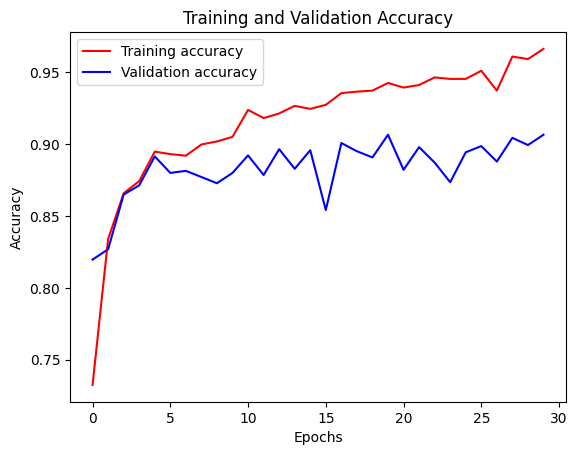

In [11]:
import matplotlib.pyplot as plt

# Check if accuracy and validation accuracy exist
if 'accuracy' in history.history and 'val_accuracy' in history.history:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
else:
    print("Accuracy data not found in history.")

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels (one-hot encoded to class labels)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step


In [13]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming y_true_classes and y_pred_classes are your true and predicted labels, and classes is a list of class names

# Calculate overall accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Calculate precision, recall, and F1 score per class (weighted)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print classification report (shows precision, recall, and F1 for each class)
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=classes))

# Display confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_true_classes, y_pred_classes))

# Print overall accuracy, precision, recall, and F1 score
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

# Accuracy per class (from confusion matrix)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print accuracy for each class
for i, class_name in enumerate(classes):
    print(f"Accuracy for {class_name}: {class_accuracy[i]:.4f}")

Classification Report:
                       precision    recall  f1-score   support

            cataract       0.92      0.95      0.94       352
            glaucoma       0.85      0.84      0.84       340
              normal       0.86      0.85      0.86       350
diabetic_retinopathy       0.99      0.99      0.99       350

            accuracy                           0.91      1392
           macro avg       0.91      0.91      0.91      1392
        weighted avg       0.91      0.91      0.91      1392

Confusion Matrix:
 [[334  10   8   0]
 [ 17 284  38   1]
 [ 11  39 299   1]
 [  0   1   4 345]]
Overall Accuracy: 0.9066
Weighted Precision: 0.9064
Weighted Recall: 0.9066
Weighted F1 Score: 0.9064
Accuracy for cataract: 0.9489
Accuracy for glaucoma: 0.8353
Accuracy for normal: 0.8543
Accuracy for diabetic_retinopathy: 0.9857
